# Module Thirteen Group Discussion, House Sales Model

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import sys
import random

from sklearn import tree
import graphviz 
from collections import defaultdict

%alias head powershell -command "& {Get-Content %s -Head 10}"

%alias tail powershell -command "& {Get-Content %s -Tail 10}"

sns.set(style="whitegrid")

Let's start by taking a peak at the data making sure everything is still OK and we can load it into a pandas dataframe

In [2]:
%head 'real-estate-data.csv'

date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
2014-05-02 00:00:00,550000.0,4.0,2.5,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
2014-05-02 00:00:00,490000.0,2.0,1.0,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA
2014-05-02 00:00:00,335000.0,2.0,2.0,1350,2560,1.0,0,0,3,1350,0,1976,0,2616 174th Ave NE,Redmond,WA 98052,USA
2014-05-02 00:00:00,482000.0,4.0,2.5,2710,35868,2

In [3]:
data = pd.read_csv("real-estate-data.csv")
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


I'll only be tackling a subset of the attributes, so I'll limit those here:

In [4]:
bfach2_data = data[["sqft_living", "condition", "city", "bathrooms", "floors", "price"]]
bfach2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 6 columns):
sqft_living    4600 non-null int64
condition      4600 non-null int64
city           4600 non-null object
bathrooms      4600 non-null float64
floors         4600 non-null float64
price          4600 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 215.7+ KB


## Helper Fucntions for Data Splitting and Model Evaluation

In [5]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def decision_tree_regress_cross_validation(builder, X, y, fold_count=10, repetitions=3):
    indices = list(range(len( X)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data_X = X.iloc[fold]
            test_data_y = y.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data_X = X.iloc[train_indices]
            train_data_y = y.iloc[train_indices]
            model = builder.fit(train_data_X, train_data_y)
            y_hat_train = model.predict(train_data_X)
            training_r_squared = model.score(train_data_X, train_data_y )
            metrics["train"].append(training_r_squared)
            
            
            
            y_hat_test = model.predict(test_data_X)
            test_r_squared = model.score(test_data_X, test_data_y)
            metrics["test"].append(test_r_squared)
    return metrics

### Constructing the Decision Tree

In [6]:
X = bfach2_data[["sqft_living", "condition", "bathrooms", "floors" ]]
y = bfach2_data[["price"]]


tree_regressor = tree.DecisionTreeRegressor()
regressor = tree_regressor.fit(X, y)

## Testing for depths 1 - 10

In [7]:
test_curve = []
train_curve = []
for k in range(1, 10):
    results = decision_tree_regress_cross_validation(tree.DecisionTreeRegressor(max_depth=k), X, y)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

We can now visualize the graph. Commented out because it takes a lot of CPU to generate.

In [8]:
dot_data = tree.export_graphviz(regressor, out_file=None, 
                     feature_names=X.columns,  
                    class_names=y.columns,  
                   filled=True, rounded=True,  
                    special_characters=True)
graph = graphviz.Source(dot_data)
#graph 

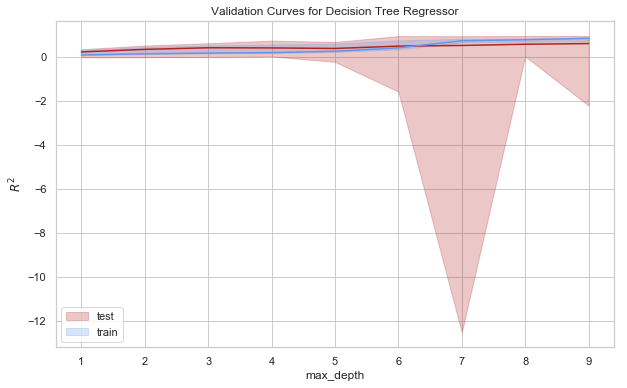

In [9]:
xs = list(range(1, 10))
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
axes = figure.add_subplot(1, 1, 1)

test_lower, test_mid, test_upper = zip(*test_curve)
train_lower, train_mid, train_upper = zip(*train_curve)

axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
axes.plot(xs, test_mid, color="firebrick")

axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
axes.plot(xs, train_mid, color="cornflowerblue")

axes.set_xticks(xs)
axes.set_xticklabels([str(x) for x in xs])

axes.legend()
axes.set_title("Validation Curves for Decision Tree Regressor")
axes.set_xlabel("max_depth")
axes.set_ylabel("$R^2$")

plt.show()
plt.close()

A depth of 7 looks like the point where we start seeing diminishing returns.

In [10]:
result = tree.DecisionTreeRegressor(max_depth=8)
result.fit(X, y)
result.score(X, y)

0.7861723006309298

An R-squared value of .786; not too bad! Could probably improve by adding in features that others did their EDA on.